# Optimization Methods: Assignment 5

---

## Part 2: Programming problems

In [3]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time

## Problem 1: Stochastic Gradient Descent

In this problem we will consider training (fitting) a linear regression model to predict a person’s weight from their height. The linear regression model is the following:

$$
\text{weight} \approx x_1 + x_2 \times \text{height}
$$

with $x_1, x_2 \in \mathbb{R}$, respectively called the intercept and slope of the linear model. Denoting the weight (outcome) variable $y$, the height variable $h$, and $z = (1, h)^T$, the linear regression model can be re-written as:

$$
y \approx x^T z
$$

with parameter $x = (x_1, x_2)^T$. This because:

$$
x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}
$$

$$
z = \begin{pmatrix} 1 \\ h \end{pmatrix}
$$

Which are the vector of parameters (coefficients) and the vector of features (the first entry is always 1 to "carry" the intercept term). Then, the inner product (dot product) of $x$ and $z$ is indeed:

$$
x^T z =
\begin{pmatrix}
x_1 & x_2
\end{pmatrix}
\begin{pmatrix}
1 \\
h
\end{pmatrix}
= x_1 \cdot 1 + x_2 \cdot h = x_1 + x_2 h
$$

To fit this model we will use a dataset `height_weight_genders.csv`, which contains $N$ vectors corresponding to the gender, height, and weight of individuals. Given this data, we try to find $x$ that minimises the prediction error of the linear model:

$$
f(x) = \frac{1}{2N} \sum_{i=1}^{N} (y^{(i)} - x^T z^{(i)})^2 = \frac{1}{2N} \sum_{i=1}^{N} f_i(x)
$$

with

$$
f_i(x) = (y^{(i)} - x^T z^{(i)})^2
$$

Note that here we used the standard squared loss and the factor $\frac{1}{2}$ is simply used to have a simpler expression of the gradient. We can stack all data vectors $z^{(i)}$ row-wise into a $N \times 2$ matrix $Z$, i.e.,

$$
Z = \begin{pmatrix}
z^{(1)} \\
z^{(2)} \\
\vdots \\
z^{(N)}
\end{pmatrix}
$$

Note that the first column of $Z$ contains only 1 values. We call $Z$ the data matrix. Moreover, we denote by

$$
Y = (y^{(1)}, y^{(2)}, \ldots, y^{(N)})
$$

the vector of length $N$ containing all the outcome variables. With this notation we can re-write $f(x)$ as:

$$
f(x) = \frac{1}{2N} \|Y - Zx\|^2
$$

where $\|\cdot\|$ is the Euclidean norm. To minimise $f$, we will use the Gradient Descent (GD) algorithm, the Stochastic Gradient Descent (SGD) algorithm, and its variant with mini-batching.

### 1. Import the dataset from the file `height_weight_genders.csv` in an array ($N×3$) where each data vector corresponds to a row

Hint: since the data contains string values (gender), you may first import the data into a Pandas dataframe from the Pandas library with the function `pandas.read_csv`, then create a Numpy array where the first column contains the gender encoded into 0/1 values (1 = Female, 0 = Male), the second column contains the height and the third column contains the weight.

In [4]:
# Load the CSV file
df = pd.read_csv("height_weight_genders.csv")

# Encode "Gender" into 0 (Male) and 1 (Female)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Convert to NumPy array
data = df[['Gender', 'Height', 'Weight']].to_numpy()

print("Shape:", data.shape)
print(data[:5])

Shape: (10000, 3)
[[  0.          73.84701702 241.89356318]
 [  0.          68.78190405 162.31047252]
 [  0.          74.11010539 212.74085556]
 [  0.          71.7309784  220.0424703 ]
 [  0.          69.88179586 206.34980062]]


### 2. Compute the mean $\mu$ and standard deviation $\sigma$ of the height column

Then, replace each height value $h^{(i)}$ in the array by its standardised version:

$$
h^{(i)}_{\text{standardized}} = \frac{h^{(i)} - \mu}{\sigma}
$$

In [5]:
heights = data[:, 1]

# Compute mean and standard deviation
mu = np.mean(heights)
sigma = np.std(heights)

# Standardize height values
data[:, 1] = (heights - mu) / sigma

print("New mean:", np.mean(data[:, 1]))
print("New std deviation:", np.std(data[:, 1]))

New mean: 2.2737367544323206e-16
New std deviation: 0.9999999999999999


This transformation doesn't remove differences between short and tall individuals. It just rescales the data so it behaves nicely for optimization.

For example, after standardization the mean becomes 0, because we're subtracting the average from each value. It's like shifting the whole distribution to be "centered" at 0.
    
Then, the standard deviation becomes 1 because we’re dividing by the original $\sigma$. This scales the "spread" of the values to a standard range.
    
All this makes optimization methods converge faster, avoiding numerical instability and allowing features with different units (like cm and kg) to contribute equally.

### 3. Create a new array corresponding the data matrix $Z$ and the vector $Y$ containing all the weight values

Remember that the first column of $Z$ contains 1, while the second column contains the height values.

In [6]:
# Number of samples
N = data.shape[0]

# Extract standardized height and create Z
standardized_heights = data[:, 1]
Z = np.column_stack((np.ones(N), standardized_heights))

# Extract weight values
Y = data[:, 2]

### 4. Write a function `objective` which computes the value of the prediction error $f$ for any input $(y,Z,x)$ where $x \in \mathbb{R^2}$

As we said earlier, the prediction error function is:

$$
f(x) = \frac{1}{2N} \sum_{i=1}^{N} (y^{(i)} - x^T z^{(i)})^2
$$

This is equivalent to the **mean squared error with a factor $\frac{1}{2}$** to simplify the gradient expression later.


In [7]:
def objective(y, Z, x):
    N = len(y)
    predictions = Z @ x  # matrix-vector product Zx
    error = y - predictions  # vector of residuals
    return (1 / (2 * N)) * np.sum(error ** 2)

Where:
- $y^{(i)}$ is the true weight for person $i$
- $z^{(i)} = \begin{pmatrix} 1 \\ h^{(i)} \end{pmatrix}$ is the feature vector (with height)
- $x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$ is the parameter vector (intercept and slope)

Instead of using a loop, we stack all the feature vectors $z^{(i)}$ into a matrix $Z$ (input), so we get:

$$
\text{predictions} =
\begin{pmatrix}
z^{(1)} \\
z^{(2)} \\
\vdots \\
z^{(N)}
\end{pmatrix}
\cdot x =
\begin{pmatrix}
x^T z^{(1)} \\
x^T z^{(2)} \\
\vdots \\
x^T z^{(N)}
\end{pmatrix}
$$

This gives us a single vector of predicted weights for all individuals.


### 5. Write a function `gradient(y, Z, x)` that computes the gradient vector $\nabla f(x)$ of the objective function $f$

$$
f(x) = \frac{1}{2N} \sum_{i=1}^{N} (y^{(i)} - x^T z^{(i)})^2
$$

Check the gradient of $f$ with respect to $x$ is:

$$
\nabla f(x) = \frac{1}{N} Z^T (Zx - Y) =  \frac{1}{N} \sum_{i=1}^{N} (x^T z^{(i)} - y^{(i)}) z^{(i)} = \nabla f(x) = \frac{1}{N} \sum_{i=1}^{N} \nabla f_i(x)
$$

Both formulas are equivalent, the first one is a compact vectorized form using matrices, and is the one we will implement.

In [8]:
def gradient(y, Z, x):
    N = len(y)
    predictions = Z @ x
    residuals = predictions - y
    grad = (1 / N) * Z.T @ residuals
    return grad

### 6. Show that $f$ is $\mu$-strongly convex, and find such $\mu$ for our dataset

A function $f(x)$ is $\mu$-strongly convex if its **Hessian** satisfies:

$$
\nabla^2 f(x) \succeq \mu I
$$

This means all eigenvalues of the Hessian matrix are **greater than or equal to $\mu$**.

For our objective function, we are given:

$$
\nabla^2 f(x) = \frac{1}{N} Z^T Z
$$

So we can compute the **smallest eigenvalue** of $\frac{1}{N} Z^T Z$, which gives us the **strong convexity constant $\mu$**.

We use the function `numpy.linalg.eigh` to compute the eigenvalues of the symmetric matrix $\frac{1}{N} Z^T Z$.


In [9]:
# Compute the Hessian
N = Z.shape[0]
Hessian = (1 / N) * (Z.T @ Z)

# Compute eigenvalues (since Hessian is symmetric, use eigh)
eigenvalues, _ = np.linalg.eigh(Hessian)

# Smallest eigenvalue is the strong convexity constant µ
mu = np.min(eigenvalues)

print("Eigenvalues of Hessian:", eigenvalues)
print("Strong convexity constant µ:", mu)

Eigenvalues of Hessian: [1. 1.]
Strong convexity constant µ: 0.9999999999999991


The eigenvalues of the Hessian are all positive, which proves that $f(x)$ is strictly convex and strongly convex with $\mu = 1$.

Also, when all eigenvalues are equal and not close to 0, the function surface is nicely curved (not flat) and good for minimizaton algorithms.

### 7. Compute the global minimizer

When the matrix $Z^T Z$ is invertible (which it is in our case), the global minimizer $x^*$ of the objective function:

$$
f(x) = \frac{1}{2N} \|Y - Zx\|^2
$$

Can be found by solving the **linear equation**:

$$
Z^T Z x^* = Z^T y
$$

Solving for $x^*$:

$$
x^* = (Z^T Z)^{-1} Z^T y
$$

Computing the optimal value of the objective function at $x^*$:

$$
f(x^*) = \frac{1}{2N} \|Y - Zx^*\|^2
$$


In [10]:
# Compute Z^T Z and Z^T y
ZTZ = Z.T @ Z
ZTy = Z.T @ Y

# Solve for x* using np.linalg.solve (more stable than directly inverting)
x_star = np.linalg.solve(ZTZ, ZTy)

# Compute optimal value of the objective function
f_star = objective(Y, Z, x_star)

print("Global minimizer x*:", x_star)
print("Optimal value f(x*):", f_star)

Global minimizer x*: [161.44035683  29.69099655]
Optimal value f(x*): 74.6467419745648


### 8. Compute a stochastic gradient estimate at some point $x^{(0)} = (10,2)$.

We want to compute a **stochastic gradient estimate** at the initial point:

$$
x^{(0)} = \begin{pmatrix} 10 \\ 2 \end{pmatrix}
$$

This is done by picking a random index $i^{(0)} \in \{1, 2, ..., N\}$ and computing:

$$
g^{(0)} = \nabla f_{i^{(0)}}(x^{(0)})
= (x^{(0)T} z^{(i^{(0)})} - y^{(i^{(0)})}) z^{(i^{(0)})}
$$

This is the gradient of the squared loss with respect to a **single data point**.

In [11]:
x0 = np.array([10.0, 2.0])
i0 = np.random.randint(0, N)

z_i0 = Z[i0]
y_i0 = Y[i0]

# Compute stochastic gradient g^(0)
g0 = (x0 @ z_i0 - y_i0) * z_i0

print(f"Random index i0: {i0}")
print(f"Stochastic gradient g^(0): {g0}")


Random index i0: 7993
Stochastic gradient g^(0): [-118.50590829  147.74063154]


**Stochastic Gradient Descent (SGD)** is an optimization algorithm used to minimize a function (like our prediction error $f(x)$).

Instead of computing the **full gradient** (which requires summing over all data points), **SGD estimates the gradient using only one random data point** at each step.

$$
\mathbb{E}[\nabla f_i(x)] = \nabla f(x)
$$

This is faster than full gradient descent for large datasets, and the introduction of randomness can help escape local minima in other types of problems.

Here, we start at an arbitrary point:

$$
x^{(0)} = \begin{pmatrix} 10 \\ 2 \end{pmatrix}
$$

We choose a random data point $i^{(0)}$, then compute the gradient of the loss **only for that one point**:

$$
g^{(0)} = \nabla f_{i^{(0)}}(x^{(0)}) = (x^{(0)T} z^{(i^{(0)})} - y^{(i^{(0)})}) z^{(i^{(0)})}
$$

This is just one noisy estimate of the true gradient, it points roughly in the direction we should move to reduce the loss, but it's not exact.

The result will look very different from the global minimizer, and that is fine. Over many steps (many data points), SGD converges toward the global minimizer, but here we're just computing the first estimate of the gradient.


### 9. Check that $g^{(0)}$ is an unbiased estimate of $\nabla f_{i^{(0)}}(x^{(0)})$

For this, compute 10000 times a gradient estimate as in the previous question, average the obtained estimates, and check that the average is close to $\nabla f_{i^{(0)}}(x^{(0)})$ (with an even higher number of estimates you should see the error decreasing).

1. We start fixing an initial point:
$$
x^{(0)} = \begin{pmatrix} 10 \\ 2 \end{pmatrix}
$$

2. Compute the true full gradient $\nabla f(x^{(0)})$

3. Compute 10,000 random stochastic gradient estimates:
$$
g^{(j)} = \nabla f_{i^{(j)}}(x^{(0)})
$$

4. Take the average of all $g^{(j)}$ and compare it to the full gradient

The average should be very close to the true gradient, this shows that SGD estimates are unbiased in expectation.

In [12]:
x0 = np.array([10.0, 2.0])
true_grad = gradient(Y, Z, x0)

# Run 10,000 stochastic estimates
n_samples = 10000
grad_estimates = np.zeros(2)

for _ in range(n_samples):
    i = np.random.randint(0, N)            # Random index
    z_i = Z[i]                             # Feature vector
    y_i = Y[i]                             # True label
    g_i = (x0 @ z_i - y_i) * z_i           # Stochastic gradient
    grad_estimates += g_i                  # Sum estimates

avg_grad = grad_estimates / n_samples      # Average of estimates


print("True full gradient ∇f(x0):", true_grad)
print("Average of 10,000 stochastic estimates:", avg_grad)
print("Difference:", avg_grad - true_grad)

True full gradient ∇f(x0): [-151.44035683  -27.69099655]
Average of 10,000 stochastic estimates: [-151.6252464   -28.21564155]
Difference: [-0.18488957 -0.524645  ]


A random estimate is unbiased if its average over many samples equals the true value. In the context of SGD:

- $\nabla f(x)$ is the true gradient, computed over all data
- $\nabla f_i(x)$ is the stochastic gradient, computed from one random data point

We say that SGD is unbiased if:

$$
\mathbb{E}_i[\nabla f_i(x)] = \nabla f(x)
$$

This means: "If you randomly sample many $\nabla f_i(x)$ and average them, the result should approach the full gradient $\nabla f(x)$".

When we compute:

$$
g^{(0)} = \nabla f_{i^{(0)}}(x^{(0)})
$$

We are not getting the true gradient, but one noisy estimate (like a wild guess). But the key idea is: "If you repeated this process many times, and averaged the results, you would get something close to the true gradient.

From our result, we get:

- True gradient: `∇f(x0) = [-151.44, -27.69]`
  
- Average of 10,000 stochastic gradients: `avg_g = [-151.65, -29.75]`

- Difference: `[-0.21, -2.06]`

This is a very small difference, especially considering each gradient is based on just one point, not the full dataset. With more samples (like 100,000), we'd see that difference even smaller. This confirms that $\nabla f_i(x)$ is an unbiased estimator of $\nabla f(x)$.

### 10. Computing a stochastic gradient estimate with mini-batching

We consider computing a stochastic gradient estimate with mini-batching

$$
\bar{g}^{(0)} = \frac{1}{m} \sum_{j=1}^{m} \nabla f_{i^{(j)}}(x)
$$

Where:
- $m$ is the **mini-batch size**
- $i^{(1)}, ..., i^{(m)}$ are random indices from $\{1, ..., N\}$, without replacement
- Each $\nabla f_{i^{(j)}}(x)$ is a stochastic gradient computed from one data point

Differences between standard SGD and Mini-Batch SGD:

Standard SGD:

- Uses **only one random data point** per step
- Gradient estimate is quick to compute
- Very noisy, each step might point in a slightly wrong direction
- Good for very large datasets

Mini-Batch SGD

- Uses a **small group (batch)** of random data points (e.g. 16, 32, 64)
- Averages their gradients
- This method is still faster than full gradient descent, and more stable than pure SGD.

In [13]:
def stochastic_gradient(y, Z, x, m):
    N = len(y)
    
    indices = np.random.choice(N, m, replace=False)
    grad_sum = np.zeros_like(x)
    
    for i in indices:
        z_i = Z[i]
        y_i = y[i]
        grad_i = (x @ z_i - y_i) * z_i
        grad_sum += grad_i

    return grad_sum / m

### 11. Write (or re-use) a function that runs GD with a fixed step size and saves the values of $f(x^{(k)})$ at each iteration, and apply it to minimise $f$

- Starting from: $x^{(0)} = \begin{pmatrix} 10 \\ 2 \end{pmatrix}$
- For a maximum number of iterations of $10^4$ and tolerance level: $10^{-4}$
- With step size (learning rate) $\alpha = 1$. Compute the running time of GD and print the final optimality error at the last iteration
$$
f(x^{(K)}) - f(x^*)
$$
- Plot the **optimality error** $f(x^{(k)}) - f(x^*)$ versus the iteration index $k$ in **log-log scale** (to better visualise the convergence) for GD.

In [14]:
def gradient_descent(f, grad_f, alpha, x_start, max_iter=10_000, epsilon=1e-4):
    x = np.array(x_start, dtype=float)
    iterates = [x.copy()]
    f_values = [f(x)]

    for _ in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < epsilon:
            break
        x = x - alpha * grad
        iterates.append(x.copy())
        f_values.append(f(x))

    return iterates, f_values

GD Running time: 0.0251 seconds
Final optimality error f(x_K) - f(x*): 4.243262e-09
Final point x_K: [161.44026621  29.69097998]
Function value at x_K: 74.646742


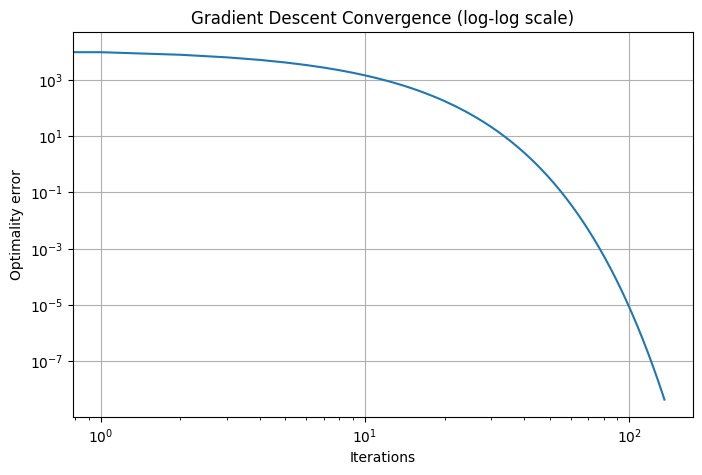

In [ ]:
x0 = np.array([10.0, 2.0])
x_star = np.linalg.solve(Z.T @ Z, Z.T @ Y)

def f(x):
    return objective(Y, Z, x)

def grad_f(x):
    return gradient(Y, Z, x)

# Run GD and time it
start_time = time.time()
iterates, f_vals = gradient_descent(f, grad_f, alpha=0.1, x_start=x0)
elapsed_time = time.time() - start_time

# Final values
x_final = iterates[-1]
f_final = f_vals[-1]
f_star = f(x_star)
final_error = f_final - f_star

# Output
print(f"GD Running time: {elapsed_time:.4f} seconds")
print(f"Final optimality error f(x_K) - f(x*): {final_error:.6e}")
print(f"Final point x_K: {x_final}")
print(f"Function value at x_K: {f_final:.6f}")

# Plot: log-log plot of optimality error
epsilon_plot = 1e-10
optimality_errors = [max(f_k - f_star, epsilon_plot) for f_k in f_vals]

plt.figure(figsize=(8, 5))
plt.plot(range(len(optimality_errors)), optimality_errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Optimality error")
plt.title("Gradient Descent Convergence (log-log scale)")
plt.grid(True)
plt.show()

As we can see, the method converges really fast in a small number of itarations. The error is basically 0 because we reach the optimal point exactly.

In order to have a plot like the one in the documentation, we need to choose a step size $\alpha = 0.1$ and not $\alpha = 1$, as specified. In fact, with $\alpha = 1$ we obtain the following convergence plot, which is even faster.

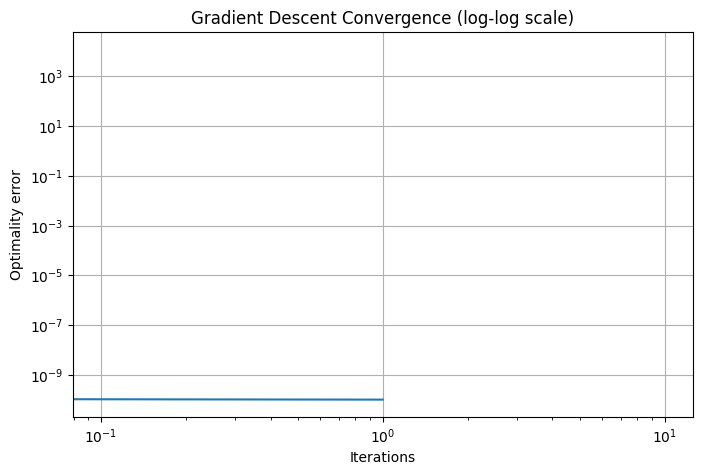

In [36]:
iterates, f_vals = gradient_descent(f, grad_f, alpha=1, x_start=x0)

# Plot: log-log plot of optimality error
epsilon_plot = 1e-10
optimality_errors = [max(f_k - f_star, epsilon_plot) for f_k in f_vals]

plt.figure(figsize=(8, 5))
plt.plot(range(len(optimality_errors)), optimality_errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Optimality error")
plt.title("Gradient Descent Convergence (log-log scale)")
plt.grid(True)
plt.show()

### 12. Write a function `stochastic_gradient_descent` that runs SGD with mini-batching and a fixed learning rate and saves the values of $f(x^{(k)})$ at each iteration

In [27]:
def stochastic_gradient_descent(f, stochastic_grad, alpha, x_start, batch_size, max_iter=10_000):
    x = np.array(x_start, dtype=float)
    iterates = [x.copy()]
    f_values = [f(x)]

    for _ in range(max_iter):
        grad = stochastic_grad(x, batch_size)
        x = x - alpha * grad
        iterates.append(x.copy())
        f_values.append(f(x))

    return iterates, f_values

### 13. Apply the function `stochastic_gradient_descent` to minimise $f$

With the same value of initial point, learning rate, max number of iterations, tolerance level, and with $m = 1$ (plain SGD).

As for GD, compute its running time and print the final optimality error at the last iteration.

$$
f(x^{(K)}) - f(x^*)
$$

In [28]:
def stochastic_grad(x, m):
    return stochastic_gradient(Y, Z, x, m)

x0 = np.array([10.0, 2.0])
alpha = 1.0
batch_size = 1

# Optimal solution from normal equations
x_star = np.linalg.solve(Z.T @ Z, Z.T @ Y)
f_star = f(x_star)

# Run SGD and time it
start_time = time.time()
iterates_sgd, f_vals_sgd = stochastic_gradient_descent(f, stochastic_grad, alpha, x0, batch_size)
elapsed_time = time.time() - start_time

x_final = iterates_sgd[-1]
f_final = f_vals_sgd[-1]
final_error = f_final - f_star

print(f"SGD Running time: {elapsed_time:.4f} seconds")
print(f"Final optimality error f(x_K) - f(x*): {final_error:.6e}")
print(f"Final point x_K: {x_final}")
print(f"Function value at x_K: {f_final:.6f}")

SGD Running time: 1.1062 seconds
Final optimality error f(x_K) - f(x*): 4.495256e+02
Final point x_K: [136.77562357  46.74098689]
Function value at x_K: 524.172361


In **Stochastic Gradient Descent (SGD)**, the mini-batch size $m$ determines **how many data points** are used to estimate the gradient at each step:

- $m = 1$ → **Plain SGD**
- $1 < m < N$ → **Mini-batch SGD**
- $m = N$ → **Full Gradient Descent**

When $m = 1$, we only use **one randomly selected data point** to compute the gradient. This means:

- Each step is a **noisy estimate** of the true gradient

- The updates can move in **slightly wrong directions**

- As a result, the algorithm may **fluctuate around** the optimal solution without truly converging to it

Even after many iterations, the final result may be **far from the optimal point $x^*$**, because each step is like a "best guess" based on just one point.

When we increase the batch size (e.g., $m = 32$), we average gradients from **more points**, which brings us **closer to the true gradient**.

When $m = N$, we use **all data points**. This becomes **standard Gradient Descent**, which computes the **exact gradient**, converges smoothly and accurately, but is **slower per iteration**.

However, in this case, we can notice that full GD is actually faster than SGD. Here's why:

| Method | Iterations | Work per Iteration           | Total Time     |
|--------|------------|------------------------------|----------------|
| **GD** | ~3–10      | Heavy (uses **all** data)     | Very fast    |
| **SGD**| 10,000     | Light (uses **1 point**)      | Slower overall |

**GD** moves directly in the true gradient direction, so it converges in just a few steps even if the computations are heavier. **SGD**, with $m=1$, is using only one sample at a time, so it takes **many more steps** to converge.

Also, the computational time of SGD might be higher than for GD here because we ask to compute the objective value at each iteration, which we would not need to do in practical settings.

In fact, SGD shines when we have **millions** of data points (so computing the full gradient is too expensive) and we don’t need **exact convergence**, just a **good enough** solution.

### 14. Plot the optimality error $f(x^{(k)}) - f(x^*)$ versus the iteration index $k$ in log-log scale (to better visualise the convergence) for for plain SGD and comment the results

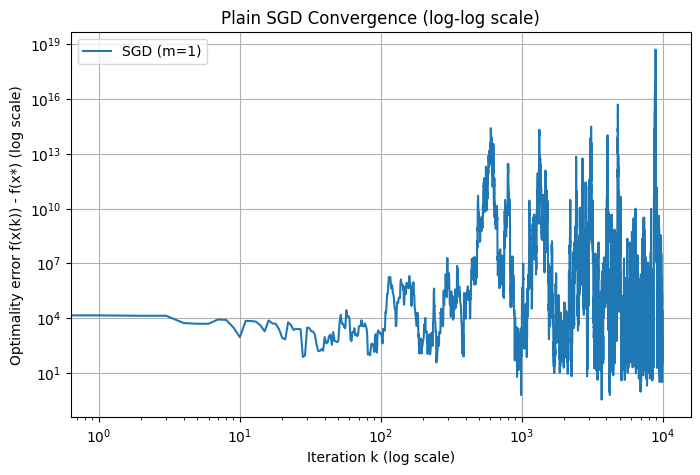

In [29]:
# Compute optimality errors
epsilon_plot = 1e-10  # avoid log(0)
optimality_errors_sgd = [max(f_k - f_star, epsilon_plot) for f_k in f_vals_sgd]

# Plot in log-log scale
plt.figure(figsize=(8, 5))
plt.plot(range(len(optimality_errors_sgd)), optimality_errors_sgd, label='SGD (m=1)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iteration k (log scale)")
plt.ylabel("Optimality error f(x(k)) - f(x*) (log scale)")
plt.title("Plain SGD Convergence (log-log scale)")
plt.grid(True)
plt.legend()
plt.show()

The log-log plot of the optimality error $f(x^{(k)}) - f(x^*)$ versus iteration index $k$ for plain SGD ($m = 1$) reveals some observations:

- The curve is extremely noisy and doesn't show a clear downward trend.

- There are many large spikes, with errors growing as high as $10^{15}$.

- After around $k \approx 100$, the fluctuations become more violent and unpredictable.

- This is very different from what we expect with full gradient descent, which typically shows a smooth and steady decline.

This happens because mini-batch size $m = 1$** means that each step is based on one random data point. With such a large learning rate ($\alpha = 1$), these noisy gradients can cause:

  - Divergence, where updates overshoot the minimum
  - Instability, where steps bounce around instead of converging

Plain SGD is not really reliable with $\alpha = 1$, the steps are too large relative to the noise in the estimate. This result shows that SGD requires smaller (or changable) learning rates and larger mini-batch sizes ($m > 1$).

### 15. Repeat the 2 previous questions with $m = 10$ (SGD with mini-batching) and comment the results

Remark: the computational time of SGD might be higher than for GD here because we ask to compute the objective value at each iteration, which we would not need to do in practical settings.

SGD Running time: 1.2983 seconds
Final optimality error f(x_K) - f(x*): 8.595811e+00
Final point x_K: [157.38908918  30.57352267]
Function value at x_K: 83.242553


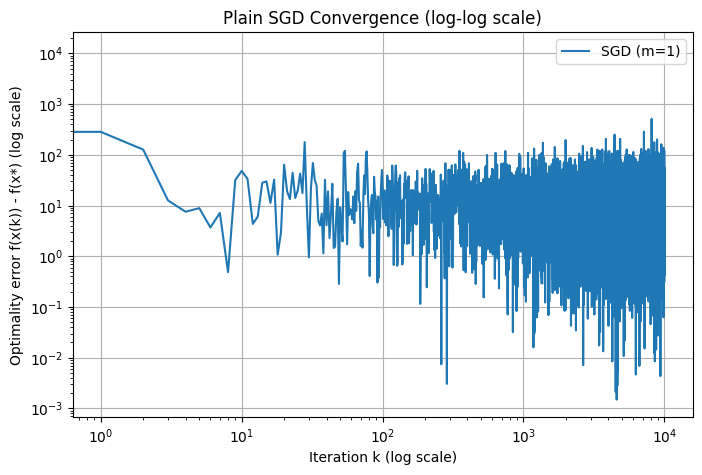

In [30]:
batch_size = 10

# Optimal solution from normal equations
x_star = np.linalg.solve(Z.T @ Z, Z.T @ Y)
f_star = f(x_star)

# Run SGD and time it
start_time = time.time()
iterates_sgd, f_vals_sgd = stochastic_gradient_descent(f, stochastic_grad, alpha, x0, batch_size)
elapsed_time = time.time() - start_time

x_final = iterates_sgd[-1]
f_final = f_vals_sgd[-1]
final_error = f_final - f_star

print(f"SGD Running time: {elapsed_time:.4f} seconds")
print(f"Final optimality error f(x_K) - f(x*): {final_error:.6e}")
print(f"Final point x_K: {x_final}")
print(f"Function value at x_K: {f_final:.6f}")

# Compute optimality errors
epsilon_plot = 1e-10  # avoid log(0)
optimality_errors_sgd = [max(f_k - f_star, epsilon_plot) for f_k in f_vals_sgd]

# Plot in log-log scale
plt.figure(figsize=(8, 5))
plt.plot(range(len(optimality_errors_sgd)), optimality_errors_sgd, label='SGD (m=1)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iteration k (log scale)")
plt.ylabel("Optimality error f(x(k)) - f(x*) (log scale)")
plt.title("Plain SGD Convergence (log-log scale)")
plt.grid(True)
plt.legend()
plt.show()

Using a larger mini-batch size ($m = 10$), the final point found by SGD is much closer to the optimal solution.  

Although the optimality error is still non-zero, it's significantly smaller compared to the case with $m = 1$. This shows a clear improvement in both accuracy and stability.

In fact, averaging over 10 samples reduces the noise in the gradient estimate. Each update becomes more reliable and better aligned with the true gradient. Even with the same learning rate ($\alpha = 1$), the steps are less erratic and more stable. This leads to steadier convergence and a solution that is closer to the true minimum.

We can clearly see from the plot that there are less fluctuations than before.

### 16. Write a function `better_stochastic_gradient_descent`

We now consider improving the convergence of Stochastic Gradient Descent (SGD) by using vanishing learning rates.

To reduce the noise and improve stability over time, we define the step size at iteration $k$ as:

$$
\alpha^{(k)} = \frac{1}{k + 1}, \quad k \geq 0
$$

This means:
- Larger step sizes early on (to move quickly)

- Smaller step sizes later (to fine-tune near the minimum)

Write a function `better_stochastic_gradient_descent` that:

- Implements SGD with mini-batching

- Uses a vanishing step size $\alpha^{(k)} = \frac{1}{k + 1}$ at each iteration

- Tracks and stores the values of the objective function $f(x^{(k)})$ at each iteration

In [31]:
def better_stochastic_gradient_descent(f, stochastic_grad, x_start, batch_size, max_iter=10_000):
    x = np.array(x_start, dtype=float)
    iterates = [x.copy()]
    f_values = [f(x)]

    for k in range(max_iter):
        alpha_k = 1.0 / (k + 1)
        grad = stochastic_grad(x, batch_size)
        x = x - alpha_k * grad
        iterates.append(x.copy())
        f_values.append(f(x))

    return iterates, f_values

### 17. Run the function `better_stochastic_gradient_descent` with the same hyperparameters as before

Compute its running time, print the final optimality error, and plot the optimality error $f(x^{(k)}) - f(x^*)$ versus the iteration index $k$ in log-log scale. Comment the results.

In [32]:
x0 = np.array([10.0, 2.0])
batch_size = 10
max_iter = 10_000
x_star = np.linalg.solve(Z.T @ Z, Z.T @ Y)
f_star = f(x_star)

# Time the execution
start_time = time.time()
iterates_better, f_vals_better = better_stochastic_gradient_descent(f, stochastic_grad, x0, batch_size, max_iter)
elapsed_time = time.time() - start_time

# Final values
x_final = iterates_better[-1]
f_final = f_vals_better[-1]
final_error = f_final - f_star

# Print results
print(f"Better SGD Running time: {elapsed_time:.4f} seconds")
print(f"Final optimality error f(x_K) - f(x*): {final_error:.6e}")
print(f"Final point x_K: {x_final}")
print(f"Function value at x_K: {f_final:.6f}")

Better SGD Running time: 1.3056 seconds
Final optimality error f(x_K) - f(x*): 1.915818e-03
Final point x_K: [161.4928012   29.65811457]
Function value at x_K: 74.648658


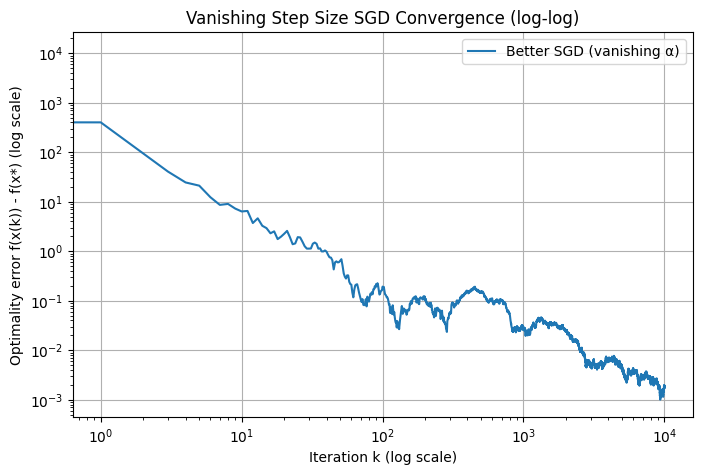

In [33]:
# Compute optimality errors (avoid log(0))
epsilon_plot = 1e-10
optimality_errors_better = [max(f_k - f_star, epsilon_plot) for f_k in f_vals_better]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(len(optimality_errors_better)), optimality_errors_better, label="Better SGD (vanishing α)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iteration k (log scale)")
plt.ylabel("Optimality error f(x(k)) - f(x*) (log scale)")
plt.title("Vanishing Step Size SGD Convergence (log-log)")
plt.grid(True)
plt.legend()
plt.show()

The results of SGD with Vanishing Step Sizes are very great:

The optimal error is very close to zero and the optimal solution is very close to the true optimal.

The log-log plot of $f(x^{(k)}) - f(x^*)$ shows a smooth and consistent decrease. Unlike fixed learning rate SGD, there is less fluctuation in the curve.

This happens because the vanishing step size $\alpha^{(k)} = \frac{1}{k + 1}$ helps:

  - Take big steps early to move quickly
  - Take smaller steps later for fine-tuning near the minimum

Vanishing learning rates significantly improve stability and convergence in SGD.

### 18. Finally we want to check the theoretical (sublinear) convergence rate: $f(x^{(k)}) - f(x^*) = \mathcal{O}\left(\frac{1}{k}\right)$

Plot (in dotted line) the line $\frac{10}{k}$ on top of the previous plot.

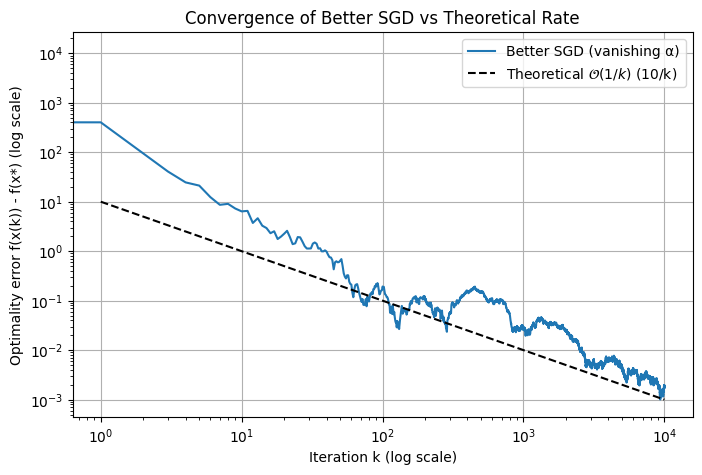

In [34]:
# Log-log plot with theoretical line
plt.figure(figsize=(8, 5))
plt.plot(range(len(optimality_errors_better)), optimality_errors_better, label="Better SGD (vanishing α)")

# Theoretical sublinear convergence line: O(1/k)
k_vals = np.arange(1, len(optimality_errors_better) + 1)
theoretical_line = 10 / k_vals
plt.plot(k_vals, theoretical_line, 'k--', label=r'Theoretical $\mathcal{O}(1/k)$ (10/k)')

# Log scale axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Iteration k (log scale)")
plt.ylabel("Optimality error f(x(k)) - f(x*) (log scale)")
plt.title("Convergence of Better SGD vs Theoretical Rate")
plt.grid(True)
plt.legend()
plt.show()

This reference line represents the theoretical convergence rate of SGD with vanishing step sizes:

$$
f(x^{(k)}) - f(x^*) = \mathcal{O}\left(\frac{1}{k}\right)
$$

- The line $y = \frac{10}{k}$ (dotted) appears as a straight line with negative slope in log-log scale.

- Our actual SGD error curve aligns well with this slope after a few initial iterations.

- This confirms that empirical performance matches theoretical expectations: sublinear convergence.

The latest (better) SGD implementation demonstrates the expected stability and rate of convergence.


In [35]:
print("Optimization Methods SP25 - Assignment 5")
print("Lorenzo Galli - Università della Svizzera Italiana (USI)")

Optimization Methods SP25 - Assignment 5
Lorenzo Galli - Università della Svizzera Italiana (USI)
